In [1]:
from tensorflow import lite
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import random, os
import shutil
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from pathlib import Path

In [2]:
# Add an additional column, mapping to the type
df = pd.read_csv(r"C:\Users\HP\OneDrive\Desktop\DRC\train.csv")

In [3]:
diagnosis_dict_binary = {
    0: 'No_DR',
    1: 'DR',
    2: 'DR',
    3: 'DR',
    4: 'DR'
}

diagnosis_dict = {
    0: 'No_DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferate_DR',
}

df['binary_type'] =  df['diagnosis'].map(diagnosis_dict_binary.get)
df['type'] = df['diagnosis'].map(diagnosis_dict.get)

In [4]:
train_intermediate, val = train_test_split(df, test_size = 0.15, stratify = df['type'])
train, test = train_test_split(train_intermediate, test_size = 0.15 / (1 - 0.15), stratify = train_intermediate['type'])

In [5]:
image_dir = Path("C:/Users/HP/OneDrive/Desktop/DRC/gaussian_filtered_images/gaussian_filtered_images")


In [6]:
# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

In [7]:
# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

In [8]:
# Shuffle the DataFrame and reset index
image_df = image_df.sample(frac=1).reset_index(drop = True)

base_dir = ''
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
os.makedirs(train_dir)

if os.path.exists(val_dir):
    shutil.rmtree(val_dir)
os.makedirs(val_dir)

if os.path.exists(test_dir):
    shutil.rmtree(test_dir)
os.makedirs(test_dir)


In [9]:
src_dir = r'C:/Users/HP/OneDrive/Desktop/DRC/gaussian_filtered_images/gaussian_filtered_images'
for index, row in train.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(train_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

for index, row in val.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(val_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

for index, row in test.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(test_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

In [10]:
train_path = 'train'
val_path = 'val'
test_path = 'test'

train_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(train_path, target_size=(224,224), shuffle = True)
val_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(val_path, target_size=(224,224), shuffle = True)
test_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(test_path, target_size=(224,224), shuffle = False)

Found 2562 images belonging to 2 classes.
Found 550 images belonging to 2 classes.
Found 550 images belonging to 2 classes.


In [11]:
# Define CNN model
model = tf.keras.Sequential([
    layers.Conv2D(8, (3,3), padding="valid", input_shape=(224,224,3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
    layers.Conv2D(16, (3,3), padding="valid", activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
    layers.Conv2D(32, (4,4), padding="valid", activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
    layers.Conv2D(64, (4,4), padding="valid", activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.15),
    layers.Dense(2, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])


In [12]:

# Train CNN model
history = model.fit(train_batches, epochs=15, validation_data=val_batches)

Epoch 1/15



81/81 [==============================] - 21s 210ms/step - loss: 0.3010 - accuracy: 0.8962 - val_loss: 0.8382 - val_accuracy: 0.5073
Epoch 2/15
81/81 [==============================] - 16s 198ms/step - loss: 0.1866 - accuracy: 0.9372 - val_loss: 0.7340 - val_accuracy: 0.4927
Epoch 3/15
81/81 [==============================] - 16s 199ms/step - loss: 0.1543 - accuracy: 0.9489 - val_loss: 0.4930 - val_accuracy: 0.7855
Epoch 4/15
81/81 [==============================] - 17s 215ms/step - loss: 0.1179 - accuracy: 0.9563 - val_loss: 0.3927 - val_accuracy: 0.8945
Epoch 5/15
81/81 [==============================] - 17s 209ms/step - loss: 0.0880 - accuracy: 0.9711 - val_loss: 0.9744 - val_accuracy: 0.5273
Epoch 6/15
81/81 [==============================] - 17s 211ms/step - loss: 0.0490 - accuracy: 0.9832 - val_loss: 0.1997 - val_accuracy: 0.9127
Epoch 7/15
81/81 [==============================] - 17s 212ms/step - loss: 0.0643 - accuracy: 0.9797 - val_loss: 0.4330 - val_accuracy: 0.8727
Epoch 8/15

In [13]:
# Define AlexNet model
def AlexNet(input_shape, num_classes):
    model = tf.keras.Sequential([
        layers.Conv2D(96, (11,11), strides=(4,4), padding='valid', input_shape=input_shape),
        layers.Activation('relu'),
        layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
        layers.Conv2D(256, (11,11), strides=(1,1), padding='valid'),
        layers.Activation('relu'),
        layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
        layers.Conv2D(384, (3,3), strides=(1,1), padding='valid'),
        layers.Activation('relu'),
        layers.Conv2D(384, (3,3), strides=(1,1), padding='valid'),
        layers.Activation('relu'),
        layers.Conv2D(256, (3,3), strides=(1,1), padding='valid'),
        layers.Activation('relu'),
        layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
        layers.Flatten(),
        layers.Dense(4096, input_shape=(input_shape[0]*input_shape[1]*3,), activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model


In [14]:
# Instantiate the AlexNet model
input_shape = (224, 224, 3)
num_classes = 2
alexnet_model = AlexNet(input_shape, num_classes)


In [15]:
# Compile AlexNet model
alexnet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [16]:
# Train AlexNet model
history_alexnet = alexnet_model.fit(train_batches, epochs=15, validation_data=val_batches)


Epoch 1/15
81/81 [==============================] - 160s 2s/step - loss: 0.7241 - accuracy: 0.5008 - val_loss: 0.6941 - val_accuracy: 0.5073
Epoch 2/15
81/81 [==============================] - 140s 2s/step - loss: 0.6934 - accuracy: 0.5020 - val_loss: 0.6933 - val_accuracy: 0.5073
Epoch 3/15
81/81 [==============================] - 139s 2s/step - loss: 0.6941 - accuracy: 0.5066 - val_loss: 0.6938 - val_accuracy: 0.5073
Epoch 4/15
81/81 [==============================] - 141s 2s/step - loss: 0.6936 - accuracy: 0.5039 - val_loss: 0.6931 - val_accuracy: 0.5073
Epoch 5/15
81/81 [==============================] - 138s 2s/step - loss: 0.6930 - accuracy: 0.5059 - val_loss: 0.6931 - val_accuracy: 0.5073
Epoch 6/15
81/81 [==============================] - 145s 2s/step - loss: 0.6933 - accuracy: 0.5090 - val_loss: 0.6930 - val_accuracy: 0.5073
Epoch 7/15
81/81 [==============================] - 141s 2s/step - loss: 0.6933 - accuracy: 0.5051 - val_loss: 0.6931 - val_accuracy: 0.5073
Epoch 8/15
81

In [17]:
# Evaluate the models on the test set
alexnet_loss, alexnet_acc = alexnet_model.evaluate(test_batches, verbose=1)
print("AlexNet Model - Loss: {:.4f}, Accuracy: {:.4f}".format(alexnet_loss, alexnet_acc))

cnn_loss, cnn_acc = model.evaluate(test_batches, verbose=1)
print("CNN Model - Loss: {:.4f}, Accuracy: {:.4f}".format(cnn_loss, cnn_acc))

18/18 [==============================] - 19s 1s/step - loss: 0.6931 - accuracy: 0.5073
AlexNet Model - Loss: 0.6931, Accuracy: 0.5073
18/18 [==============================] - 5s 275ms/step - loss: 0.2651 - accuracy: 0.9473
CNN Model - Loss: 0.2651, Accuracy: 0.9473


In [18]:
import pandas as pd

# Create a DataFrame to store model accuracies
model_accuracies = pd.DataFrame({
    'Model': ['AlexNet', 'CNN'],
    'Accuracy': [alexnet_acc, cnn_acc]
})

# Print the DataFrame
print(model_accuracies)


     Model  Accuracy
0  AlexNet  0.507273
1      CNN  0.947273


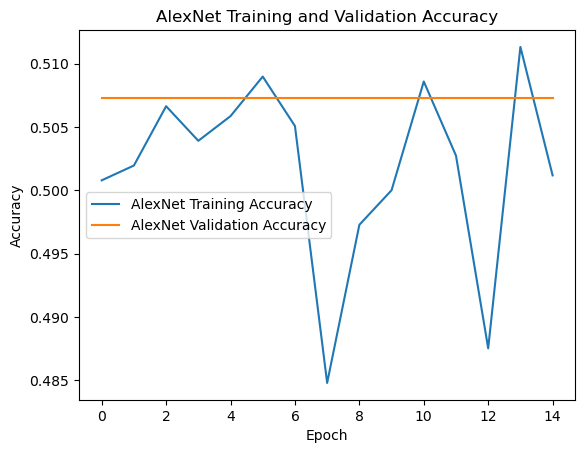

In [19]:
# Plot training and validation accuracy for AlexNet
plt.plot(history_alexnet.history['accuracy'], label='AlexNet Training Accuracy')
plt.plot(history_alexnet.history['val_accuracy'], label='AlexNet Validation Accuracy')
plt.title('AlexNet Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

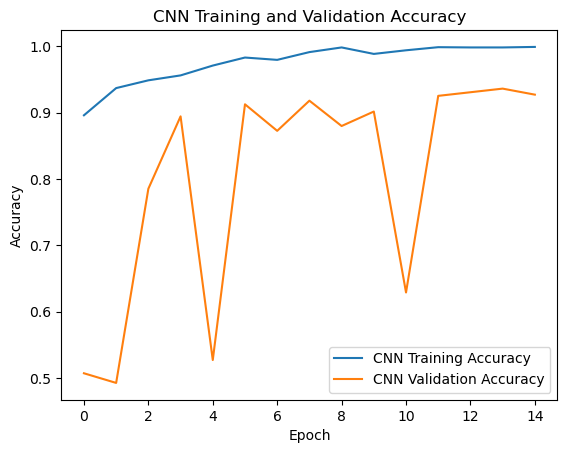

In [20]:
# Plot training and validation accuracy for CNN
plt.plot(history.history['accuracy'], label='CNN Training Accuracy')
plt.plot(history.history['val_accuracy'], label='CNN Validation Accuracy')
plt.title('CNN Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

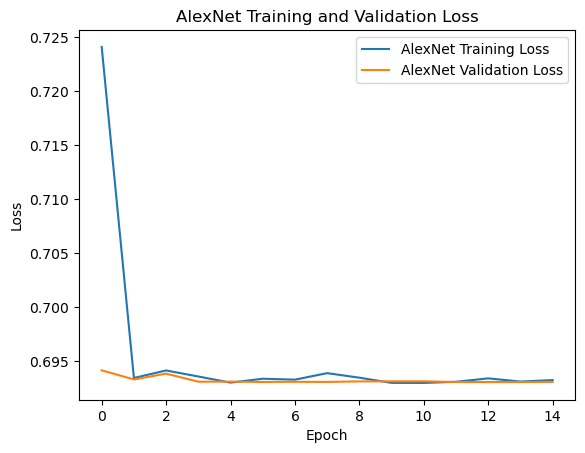

In [21]:
# Plot training and validation loss for AlexNet
plt.plot(history_alexnet.history['loss'], label='AlexNet Training Loss')
plt.plot(history_alexnet.history['val_loss'], label='AlexNet Validation Loss')
plt.title('AlexNet Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

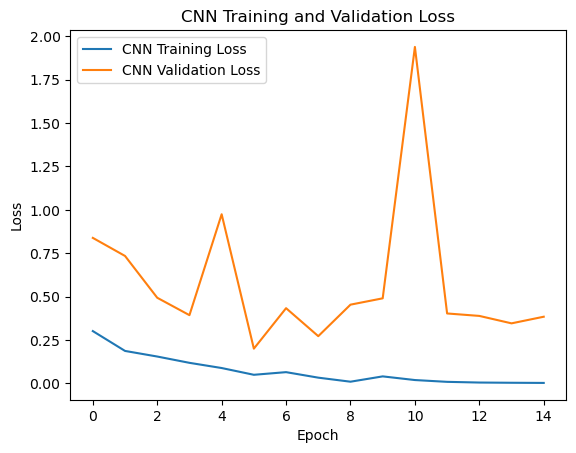

In [22]:
# Plot training and validation loss for CNN
plt.plot(history.history['loss'], label='CNN Training Loss')
plt.plot(history.history['val_loss'], label='CNN Validation Loss')
plt.title('CNN Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()